In [1]:
import os
import rootpath
import sys
sys.path.append(rootpath.detect())

import numpy as np
import pickle as pkl
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon

In [2]:
def save_fig(fig, name=None):
    pass
    figname_stub = script_dir.split('/')[-1]
    if name is None:
        filename = figname_stub+"_"+fig.get_title()
    else:
        filename = figname_stub+"_"+name
    
    savedirs = [os.path.join(script_dir, "figures/"),
                "/home/finley/phd/papers/SAF-driven-EMO/figures/"]
    for d in savedirs:
        fig.savefig(os.path.join(d, filename+".png"), dpi=300, facecolor=None, edgecolor=None,
        orientation='portrait', pad_inches=0.12)
        fig.savefig(os.path.join(d, filename+".pdf"), bbox_inches = 'tight', pad_inches = 0, dpi=300, facecolor=None, edgecolor=None,
        orientation='portrait')
    

In [3]:
def IQR(dist, axis=0):
    return np.percentile(dist, 75, axis=axis) - np.percentile(dist, 25, axis=axis)

In [4]:
# establish up data paths
try: 
    get_ipython().__class__.__name__
    script_dir = os.path.dirname(os.path.realpath(__file__))
except:
     script_dir = './'
if not os.path.isdir('./figures'):
    os.makedirs("./figures")

In [5]:
import matplotlib
from matplotlib.ticker import StrMethodFormatter
from matplotlib.ticker import MaxNLocator


matplotlib.rcParams['mathtext.fontset'] = 'stix';
matplotlib.rcParams['font.family'] = 'STIXGeneral';
matplotlib.rcParams['font.size'] = 15 ;
matplotlib.rcParams['legend.fontsize'] = 11
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [6]:
markers = ["o", "d", "^", "P", "X", "v", "*", "s", '>']
cmap = matplotlib.cm.tab10
# colors = cmap(np.linspace(0, 1, len(result_dirs)+1))
colors = cmap([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [7]:
REPORT_TABLE_DIR= '/home/finley/phd/papers/SAF-driven-EMO/tables/'
X_LIMIT = 150

In [8]:
names = ['Mpoi', 'ParEgo', 'Saf_ei', 'Saf_$\\mu$', 'SmsEgo_ei', 'SmsEgo_$\\mu$', 'lhs', 'SmsEgoMu', 'SmsEgo']
true_names = ['MPoI', 'ParEGO', 'SAF$_{EI}$', 'SAF${\mu}$', 'SMS-EGO: ei old', 'SMS-EGO: $\mu$ old', 'LHS', 'SMS-EGO$_\mu$', "SMS-EGO"]

D_names = {a:b for a, b in zip(names, true_names)}

In [9]:
chosen_problems = ['wfg1_2obj_3dim',
                   'wfg1_3obj_4dim',
                   'wfg1_4obj_5dim',
                   'wfg2_2obj_6dim',
                   'wfg2_3obj_6dim',
                   'wfg2_4obj_10dim',
                   'wfg3_2obj_6dim',
                   'wfg3_3obj_10dim',
                   'wfg3_4obj_10dim',
                   'wfg4_2obj_6dim',
                   'wfg4_3obj_8dim',
                   'wfg4_4obj_8dim',
                   'wfg5_2obj_6dim',
                   'wfg5_3obj_8dim',
                   'wfg5_4obj_10dim',
                   'wfg6_2obj_10dim',
                   'wfg6_3obj_6dim',
                   'wfg6_4obj_12dim']

In [10]:
chosen_optimisers = [n for n in names if n not in ['SmsEgo_ei', 'SmsEgo_$\\mu$']]
chosen_optimisers = [chosen_optimisers[i] for i in [4, 0, 1, 6, 5, 2, 3]]
chosen_optimisers

['lhs', 'Mpoi', 'ParEgo', 'SmsEgo', 'SmsEgoMu', 'Saf_ei', 'Saf_$\\mu$']

In [11]:
def add_com(df, mask, com):
    best_inds =  [*zip(*np.where(mask == 1))] 
    for i, j in best_inds:
        df.iloc[i, j] = com + df.iloc[i, j]
    return df

In [12]:
pkl_filenames = 'results_sorted_newsms.pkl'
parent_dir = os.path.join(rootpath.detect(), 'experiments/comp/data')
results = {o:{'path':os.path.join(parent_dir, o, 'pkl_data/'+pkl_filenames)} for o in chosen_problems}
for key, result in results.items():
    with open(result['path'], 'rb') as infile:
        results[key]['data'] = pkl.load(infile) 

In [13]:
def get_rawdata(problem_data, metric, optimisers):
    a = np.array([problem_data[opt][metric][:, :150] for opt in optimisers])
    return a

def get_med_iqrs(problem_data, metric, optimisers):
    hv_raw = get_rawdata(problem_data, metric, optimisers)
    hv_final = hv_raw[:, :, -1]
    meds = np.median(hv_final, axis=1)
    iqrs = IQR(hv_final, axis=1)
    return meds, iqrs

def get_equiv(problem_data, metric, optimisers, invert):
    raw = get_rawdata(problem_data, metric, optimisers)
    raw_final = raw[:, :, -1]
    meds, iqrs = get_med_iqrs(problem_data, metric, optimisers) 
    if invert:
        best_ind = np.argmin(meds)
    else:
        best_ind = np.argmax(meds)
        

    equiv = np.zeros(len(optimisers), dtype=bool)
    best = np.zeros(len(optimisers), dtype=bool)
    best[best_ind] = True
    ref = raw_final[best_ind]
    similar = False
    
    ps= np.zeros(len(optimisers)) 
    for ind in range(len(optimisers)):
        if ind != best_ind:
            w, p = wilcoxon(ref, raw_final[ind])
            ps[ind] = p
        else:
            ps[ind] = 1.
            
    order = np.argsort(ps)
    for i, ind in enumerate(order[:-1]):
        denom = (len(optimisers)-1) -i
        similar = True if ps[ind]>0.05/denom else False
        equiv[ind] = similar
    return best, equiv 

meds, iqrs = get_med_iqrs(results['wfg1_2obj_3dim']['data'], 'hypervolume', chosen_optimisers)
b, q = get_equiv(results['wfg1_2obj_3dim']['data'], 'hypervolume', chosen_optimisers, invert=False)

In [14]:
def gen_table_data(results, metric, problems, optimisers):
    if metric == "igd+":
        invert= True
    else:
        invert = False
    D = np.zeros((len(optimisers), len(problems)*2)) # table data matrix, medians IQR
    B = np.zeros((len(optimisers), len(problems)*2)) # mask of best values
    E = np.zeros((len(optimisers), len(problems)*2)) # mask of equivalencies  
    
    for i, prob in enumerate(problems):
        meds, iqrs = get_med_iqrs(results[prob]['data'], metric, optimisers)
        best, equiv = get_equiv(results[prob]['data'], metric, optimisers, invert)
        
        D[:, i*2] = meds
        D[:, i*2+1] = iqrs 
        
        B[:, i*2] = best 
        B[:, i*2+1] = best 
        
        E[:, i*2] = equiv
        E[:, i*2+1] = equiv 
    return D, B, E
D, B, E = gen_table_data(results, 'hypervolume', chosen_problems, chosen_optimisers)
D2, B2, E2 = gen_table_data(results, 'igd+', chosen_problems, chosen_optimisers)

In [15]:
print("Best or equivalent HPV: ")
for i, v in enumerate((np.sum(B, axis=1)+np.sum(E, axis=1))/2):
    print(chosen_optimisers[i], "\t", int(v))

Best or equivalent HPV: 
lhs 	 0
Mpoi 	 3
ParEgo 	 8
SmsEgo 	 10
SmsEgoMu 	 8
Saf_ei 	 4
Saf_$\mu$ 	 12


In [16]:
print("Best or equivalent igd+: ")
for i, v in enumerate((np.sum(B2, axis=1)+np.sum(E2, axis=1))/2):
    print(chosen_optimisers[i], "\t", int(v))

Best or equivalent igd+: 
lhs 	 0
Mpoi 	 1
ParEgo 	 8
SmsEgo 	 10
SmsEgoMu 	 10
Saf_ei 	 4
Saf_$\mu$ 	 12


In [17]:
D[[3, 6], ::2]
D[[3, 6], ::2].argmax(axis=0).sum()

11

In [18]:
def gen_table(results, metric, problems, optimisers):
    D, B, E = gen_table_data(results, metric, problems, optimisers)
#     IQR_mask = np.zeros_like(D, dtype=bool)
#     IQR_mask[:, ::2] = True
    
    formatted_problems = [p.replace('wfg', 'WFG').replace('_', ' ').replace('obj', '\nobj').replace('dim', '\ndim') for p in problems] 
    formatted_optimisers = [D_names[o] for o in optimisers] 
    
    df_data = D.round(3)
    df_data = df_data.astype(str)
    
    col_index = pd.MultiIndex.from_product([formatted_problems, ["Median", "IQR"]])
    df = pd.DataFrame(df_data, index=formatted_optimisers, columns=col_index)
     
    df[df.columns[1::2]] = '\scriptsize \textit{'+df[df.columns[1::2]]+'}'
    df = add_com(df, B, r'\best ')
    df = add_com(df, E, r'\statsimilar ')
    return df
M = gen_table(results, 'hypervolume', chosen_problems, chosen_optimisers)
M

WFG1 2\nobj 3\ndim                                           \
                           Median                                      IQR   
LHS                         0.831               \scriptsize \textit{0.092}   
MPoI                        1.619               \scriptsize \textit{0.459}   
ParEGO                \best 2.018         \best \scriptsize \textit{0.269}   
SMS-EGO                     1.827               \scriptsize \textit{0.161}   
SMS-EGO$_\mu$               1.814               \scriptsize \textit{0.236}   
SAF$_{EI}$                  1.428               \scriptsize \textit{0.172}   
SAF${\mu}$     \statsimilar 1.976  \statsimilar \scriptsize \textit{0.234}   

               WFG1 3\nobj 4\ndim                                           \
                           Median                                      IQR   
LHS                         3.083               \scriptsize \textit{0.421}   
MPoI                        6.242               \scriptsize \textit{1.507}   
ParEGO         \statsimilar 8.126  \statsimilar \scriptsize \textit{1.544}   
SMS-EGO               \best 8.224          \best \scriptsize \textit{1.31}   
SMS-EGO$_\mu$  \statsimilar 8.134   \statsimilar \scriptsize \textit{1.02}   
SAF$_{EI}$                  5.785               \scriptsize \textit{1.008}   
SAF${\mu}$     \statsimilar 7.972  \statsimilar \scriptsize \textit{1.855}   

                WFG1 4\nobj 5\ndim                                           \
                            Median                                      IQR   
LHS                         12.299               \scriptsize \textit{1.649}   
MPoI                        21.803               \scriptsize \textit{6.015}   
ParEGO           \statsimilar 29.0  \statsimilar \scriptsize \textit{3.865}   
SMS-EGO        \statsimilar 29.756  \statsimilar \scriptsize \textit{8.576}   
SMS-EGO$_\mu$   \statsimilar 30.33  \statsimilar \scriptsize \textit{9.137}   
SAF$_{EI}$                  23.681               \scriptsize \textit{2.678}   
SAF${\mu}$            \best 30.651         \best \scriptsize \textit{6.804}   

              WFG2 2\nobj 6\ndim                                    \
                          Median                               IQR   
LHS                        7.947        \scriptsize \textit{0.299}   
MPoI                       7.551        \scriptsize \textit{1.366}   
ParEGO               \best 8.546  \best \scriptsize \textit{0.439}   
SMS-EGO                    7.708        \scriptsize \textit{0.914}   
SMS-EGO$_\mu$              7.822        \scriptsize \textit{0.673}   
SAF$_{EI}$                 7.742        \scriptsize \textit{0.553}   
SAF${\mu}$                 7.964         \scriptsize \textit{0.43}   

                      WFG2 3\nobj 6\ndim  \
                                  Median   
LHS                               67.375   
MPoI           \statsimilar \best 74.777   
ParEGO                             74.33   
SMS-EGO                           68.408   
SMS-EGO$_\mu$                     67.351   
SAF$_{EI}$                        70.915   
SAF${\mu}$           \statsimilar 72.149   

                                                              ...  \
                                                         IQR  ...   
LHS                               \scriptsize \textit{4.271}  ...   
MPoI           \statsimilar \best \scriptsize \textit{6.555}  ...   
ParEGO                            \scriptsize \textit{4.332}  ...   
SMS-EGO                           \scriptsize \textit{5.308}  ...   
SMS-EGO$_\mu$                      \scriptsize \textit{8.57}  ...   
SAF$_{EI}$                        \scriptsize \textit{4.244}  ...   
SAF${\mu}$           \statsimilar \scriptsize \textit{6.858}  ...   

                WFG5 3\nobj 8\ndim                                           \
                            Median                                      IQR   
LHS                         30.184               \scriptsize \textit{1.707}   
MPoI      

In [19]:
for opt, b, e in zip(chosen_optimisers, B.sum(axis=1), E.sum(axis=1)):
    print(opt, (b+e)/2)

lhs 0.0
Mpoi 3.0
ParEgo 8.0
SmsEgo 10.0
SmsEgoMu 8.0
Saf_ei 4.0
Saf_$\mu$ 12.0


In [20]:
M_hv_1 = gen_table(results, 'hypervolume', chosen_problems[:6], chosen_optimisers)
with open(os.path.join(REPORT_TABLE_DIR, 'hv_table_1.tex'), "w") as outfile:
    print(M_hv_1.to_latex(index=True, escape=False), file=outfile)
M_hv_1

WFG1 2\nobj 3\ndim                                           \
                           Median                                      IQR   
LHS                         0.831               \scriptsize \textit{0.092}   
MPoI                        1.619               \scriptsize \textit{0.459}   
ParEGO                \best 2.018         \best \scriptsize \textit{0.269}   
SMS-EGO                     1.827               \scriptsize \textit{0.161}   
SMS-EGO$_\mu$               1.814               \scriptsize \textit{0.236}   
SAF$_{EI}$                  1.428               \scriptsize \textit{0.172}   
SAF${\mu}$     \statsimilar 1.976  \statsimilar \scriptsize \textit{0.234}   

               WFG1 3\nobj 4\ndim                                           \
                           Median                                      IQR   
LHS                         3.083               \scriptsize \textit{0.421}   
MPoI                        6.242               \scriptsize \textit{1.507}   
ParEGO         \statsimilar 8.126  \statsimilar \scriptsize \textit{1.544}   
SMS-EGO               \best 8.224          \best \scriptsize \textit{1.31}   
SMS-EGO$_\mu$  \statsimilar 8.134   \statsimilar \scriptsize \textit{1.02}   
SAF$_{EI}$                  5.785               \scriptsize \textit{1.008}   
SAF${\mu}$     \statsimilar 7.972  \statsimilar \scriptsize \textit{1.855}   

                WFG1 4\nobj 5\ndim                                           \
                            Median                                      IQR   
LHS                         12.299               \scriptsize \textit{1.649}   
MPoI                        21.803               \scriptsize \textit{6.015}   
ParEGO           \statsimilar 29.0  \statsimilar \scriptsize \textit{3.865}   
SMS-EGO        \statsimilar 29.756  \statsimilar \scriptsize \textit{8.576}   
SMS-EGO$_\mu$   \statsimilar 30.33  \statsimilar \scriptsize \textit{9.137}   
SAF$_{EI}$                  23.681               \scriptsize \textit{2.678}   
SAF${\mu}$            \best 30.651         \best \scriptsize \textit{6.804}   

              WFG2 2\nobj 6\ndim                                    \
                          Median                               IQR   
LHS                        7.947        \scriptsize \textit{0.299}   
MPoI                       7.551        \scriptsize \textit{1.366}   
ParEGO               \best 8.546  \best \scriptsize \textit{0.439}   
SMS-EGO                    7.708        \scriptsize \textit{0.914}   
SMS-EGO$_\mu$              7.822        \scriptsize \textit{0.673}   
SAF$_{EI}$                 7.742        \scriptsize \textit{0.553}   
SAF${\mu}$                 7.964         \scriptsize \textit{0.43}   

                      WFG2 3\nobj 6\ndim  \
                                  Median   
LHS                               67.375   
MPoI           \statsimilar \best 74.777   
ParEGO                             74.33   
SMS-EGO                           68.408   
SMS-EGO$_\mu$                     67.351   
SAF$_{EI}$                        70.915   
SAF${\mu}$           \statsimilar 72.149   

                                                              \
                                                         IQR   
LHS                               \scriptsize \textit{4.271}   
MPoI           \statsimilar \best \scriptsize \textit{6.555}   
ParEGO                            \scriptsize \textit{4.332}   
SMS-EGO                           \scriptsize \textit{5.308}   
SMS-EGO$_\mu$                      \scriptsize \textit{8.57}   
SAF$_{EI}$                        \scriptsize \textit{4.244}   
SAF${\mu}$           \statsimilar \scriptsize \textit{6.858}   

                WFG2 4\nobj 10\ndim                                            
                             Median                                       IQR  
LHS                         499.637               \scriptsize \textit{26.438}  
MPoI           \statsimilar 559.977  \statsimilar \s

In [21]:
M_hv_2 = gen_table(results, 'hypervolume', chosen_problems[6:12], chosen_optimisers)
with open(os.path.join(REPORT_TABLE_DIR, 'hv_table_2.tex'), "w") as outfile:
    print(M_hv_2.to_latex(index=True, escape=False), file=outfile)
M_hv_2


WFG3 2\nobj 6\ndim                                    \
                          Median                               IQR   
LHS                        7.902        \scriptsize \textit{0.263}   
MPoI                       8.796        \scriptsize \textit{0.842}   
ParEGO                     9.293        \scriptsize \textit{0.314}   
SMS-EGO              \best 10.64  \best \scriptsize \textit{0.058}   
SMS-EGO$_\mu$             10.604        \scriptsize \textit{0.065}   
SAF$_{EI}$                10.103        \scriptsize \textit{0.154}   
SAF${\mu}$                10.556        \scriptsize \textit{0.054}   

               WFG3 3\nobj 10\ndim                                           \
                            Median                                      IQR   
LHS                         50.784               \scriptsize \textit{1.518}   
MPoI                        59.086                 \scriptsize \textit{7.4}   
ParEGO                      62.675               \scriptsize \textit{3.605}   
SMS-EGO        \statsimilar 68.306  \statsimilar \scriptsize \textit{1.826}   
SMS-EGO$_\mu$          \best 68.68         \best \scriptsize \textit{1.019}   
SAF$_{EI}$                  66.118               \scriptsize \textit{1.308}   
SAF${\mu}$                  67.429               \scriptsize \textit{1.429}   

                WFG3 4\nobj 10\ndim                                            \
                             Median                                       IQR   
LHS                         416.038               \scriptsize \textit{12.546}   
MPoI                        505.124                 \scriptsize \textit{28.3}   
ParEGO                      500.097               \scriptsize \textit{20.304}   
SMS-EGO                     519.061                \scriptsize \textit{31.79}   
SMS-EGO$_\mu$               514.673               \scriptsize \textit{30.592}   
SAF$_{EI}$            \best 536.871         \best \scriptsize \textit{10.861}   
SAF${\mu}$     \statsimilar 533.867  \statsimilar \scriptsize \textit{16.169}   

               WFG4 2\nobj 6\ndim                                           \
                           Median                                      IQR   
LHS                         5.919               \scriptsize \textit{0.369}   
MPoI                        6.357               \scriptsize \textit{0.485}   
ParEGO         \statsimilar 7.198  \statsimilar \scriptsize \textit{0.322}   
SMS-EGO               \best 7.373         \best \scriptsize \textit{0.401}   
SMS-EGO$_\mu$   \statsimilar 7.35  \statsimilar \scriptsize \textit{0.367}   
SAF$_{EI}$     \statsimilar 7.231  \statsimilar \scriptsize \textit{0.381}   
SAF${\mu}$     \statsimilar 7.303  \statsimilar \scriptsize \textit{0.495}   

                WFG4 3\nobj 8\ndim                                           \
                            Median                                      IQR   
LHS                         37.832                \scriptsize \textit{3.71}   
MPoI                        49.408               \scriptsize \textit{4.491}   
ParEGO                      52.602               \scriptsize \textit{9.012}   
SMS-EGO        \statsimilar 52.616  \statsimilar \scriptsize \textit{8.817}   
SMS-EGO$_\mu$         \best 57.425         \best \scriptsize \textit{5.927}   
SAF$_{EI}$     \statsimilar 56.484  \statsimilar \scriptsize \textit{3.123}   
SAF${\mu}$      \statsimilar 55.83  \statsimilar \scriptsize \textit{2.998}   

                 WFG4 4\nobj 8\ndim                                            
                             Median                                       IQR  
LHS                         314.758               \scriptsize \textit{19.139}  
MPoI                        447.613              \scriptsize \textit{149.224}  
ParEGO                      488.993              \scriptsize \textit{131.446}  
SMS-EGO        \statsimilar 517.973  \statsimilar \scriptsize \textit{54.054}  
SMS-EGO$_\mu$         \best 560.487         \b

In [22]:
M_hv_3 = gen_table(results, 'hypervolume', chosen_problems[12:], chosen_optimisers)
with open(os.path.join(REPORT_TABLE_DIR, 'hv_table_3.tex'), "w") as outfile:
    print(M_hv_3.to_latex(index=True, escape=False), file=outfile)
M_hv_3


WFG5 2\nobj 6\ndim                                           \
                           Median                                      IQR   
LHS                         4.786               \scriptsize \textit{0.185}   
MPoI                        5.824               \scriptsize \textit{0.511}   
ParEGO                \best 6.563         \best \scriptsize \textit{0.331}   
SMS-EGO        \statsimilar 6.475  \statsimilar \scriptsize \textit{0.603}   
SMS-EGO$_\mu$               6.007               \scriptsize \textit{0.541}   
SAF$_{EI}$                  5.296               \scriptsize \textit{0.365}   
SAF${\mu}$                  6.158               \scriptsize \textit{0.388}   

                WFG5 3\nobj 8\ndim                                           \
                            Median                                      IQR   
LHS                         30.184               \scriptsize \textit{1.707}   
MPoI                        39.407               \scriptsize \textit{6.208}   
ParEGO         \statsimilar 40.123  \statsimilar \scriptsize \textit{5.458}   
SMS-EGO               \best 43.535         \best \scriptsize \textit{5.478}   
SMS-EGO$_\mu$  \statsimilar 42.774  \statsimilar \scriptsize \textit{3.529}   
SAF$_{EI}$                  36.186               \scriptsize \textit{4.376}   
SAF${\mu}$     \statsimilar 42.468  \statsimilar \scriptsize \textit{3.641}   

              WFG5 4\nobj 10\ndim                                    \
                           Median                               IQR   
LHS                       213.407       \scriptsize \textit{12.576}   
MPoI                      262.216       \scriptsize \textit{59.318}   
ParEGO                    279.477       \scriptsize \textit{46.219}   
SMS-EGO                   281.513       \scriptsize \textit{50.994}   
SMS-EGO$_\mu$             281.026       \scriptsize \textit{56.115}   
SAF$_{EI}$                260.963       \scriptsize \textit{33.522}   
SAF${\mu}$          \best 324.399  \best \scriptsize \textit{37.05}   

              WFG6 2\nobj 10\ndim                                    \
                           Median                               IQR   
LHS                         4.484        \scriptsize \textit{0.325}   
MPoI                        6.266        \scriptsize \textit{0.466}   
ParEGO                      7.026        \scriptsize \textit{0.365}   
SMS-EGO                     6.942        \scriptsize \textit{0.713}   
SMS-EGO$_\mu$                6.78        \scriptsize \textit{0.846}   
SAF$_{EI}$                  7.233        \scriptsize \textit{0.287}   
SAF${\mu}$            \best 7.631  \best \scriptsize \textit{0.426}   

              WFG6 3\nobj 6\ndim                                    \
                          Median                               IQR   
LHS                       44.527        \scriptsize \textit{2.601}   
MPoI                      60.758        \scriptsize \textit{5.591}   
ParEGO                     54.55        \scriptsize \textit{2.777}   
SMS-EGO                   64.476        \scriptsize \textit{5.146}   
SMS-EGO$_\mu$             63.657        \scriptsize \textit{7.061}   
SAF$_{EI}$                63.811        \scriptsize \textit{4.356}   
SAF${\mu}$          \best 69.028  \best \scriptsize \textit{1.786}   

                WFG6 4\nobj 12\ndim                                            
                             Median                                       IQR  
LHS                         288.389               \scriptsize \textit{12.287}  
MPoI                          391.3               \scriptsize \textit{69.111}  
ParEGO                      411.117                \scriptsize \textit{60.56}  
SMS-EGO        \statsimilar 488.723  \statsimilar \scriptsize \textit{31.602}  
SMS-EGO$_\mu$          \best 492.46         \best \scriptsize \textit{31.028}  
SAF$_{EI}$                   432.85                 \scriptsize \textit{18.4}  
SAF${\mu}$                  445.447              

In [23]:
M_igd_1 = gen_table(results, 'igd+', chosen_problems[:6], chosen_optimisers)
with open(os.path.join(REPORT_TABLE_DIR, 'igd_table_1.tex'), "w") as outfile:
    print(M_igd_1.to_latex(index=True, escape=False), file=outfile)
M_igd_1

WFG1 2\nobj 3\ndim                                           \
                           Median                                      IQR   
LHS                         1.563               \scriptsize \textit{0.034}   
MPoI                        1.063               \scriptsize \textit{0.269}   
ParEGO                \best 0.969         \best \scriptsize \textit{0.036}   
SMS-EGO                     0.993               \scriptsize \textit{0.035}   
SMS-EGO$_\mu$  \statsimilar 0.992  \statsimilar \scriptsize \textit{0.035}   
SAF$_{EI}$                  1.324               \scriptsize \textit{0.067}   
SAF${\mu}$                  1.014               \scriptsize \textit{0.035}   

               WFG1 3\nobj 4\ndim                                           \
                           Median                                      IQR   
LHS                         1.981               \scriptsize \textit{0.058}   
MPoI                        1.483               \scriptsize \textit{0.231}   
ParEGO         \statsimilar 1.318  \statsimilar \scriptsize \textit{0.113}   
SMS-EGO        \statsimilar 1.314  \statsimilar \scriptsize \textit{0.114}   
SMS-EGO$_\mu$         \best 1.297         \best \scriptsize \textit{0.092}   
SAF$_{EI}$                  1.636                 \scriptsize \textit{0.1}   
SAF${\mu}$     \statsimilar 1.343  \statsimilar \scriptsize \textit{0.184}   

               WFG1 4\nobj 5\ndim                                           \
                           Median                                      IQR   
LHS                          2.26               \scriptsize \textit{0.078}   
MPoI                        1.883               \scriptsize \textit{0.187}   
ParEGO         \statsimilar 1.655  \statsimilar \scriptsize \textit{0.146}   
SMS-EGO        \statsimilar 1.634  \statsimilar \scriptsize \textit{0.248}   
SMS-EGO$_\mu$         \best 1.614         \best \scriptsize \textit{0.286}   
SAF$_{EI}$                  1.814               \scriptsize \textit{0.128}   
SAF${\mu}$     \statsimilar 1.621  \statsimilar \scriptsize \textit{0.187}   

              WFG2 2\nobj 6\ndim                                    \
                          Median                               IQR   
LHS                        0.508        \scriptsize \textit{0.069}   
MPoI                       0.563        \scriptsize \textit{0.213}   
ParEGO               \best 0.433  \best \scriptsize \textit{0.086}   
SMS-EGO                     0.57         \scriptsize \textit{0.15}   
SMS-EGO$_\mu$              0.538        \scriptsize \textit{0.129}   
SAF$_{EI}$                 0.553        \scriptsize \textit{0.094}   
SAF${\mu}$                  0.53        \scriptsize \textit{0.094}   

              WFG2 3\nobj 6\ndim                                    \
                          Median                               IQR   
LHS                        0.749        \scriptsize \textit{0.159}   
MPoI                 \best 0.653  \best \scriptsize \textit{0.162}   
ParEGO                     0.746        \scriptsize \textit{0.201}   
SMS-EGO                    0.878        \scriptsize \textit{0.188}   
SMS-EGO$_\mu$              0.895        \scriptsize \textit{0.248}   
SAF$_{EI}$                 0.891        \scriptsize \textit{0.212}   
SAF${\mu}$                 0.818        \scriptsize \textit{0.258}   

              WFG2 4\nobj 10\ndim                                           
                           Median                                      IQR  
LHS                         0.635               \scriptsize \textit{0.081}  
MPoI                        0.652               \scriptsize \textit{0.177}  
ParEGO          \statsimilar 0.55   \statsimilar \scriptsize \textit{0.16}  
SMS-EGO        \statsimilar 0.567  \statsimilar \scriptsize \textit{0.089}  
SMS-EGO$_\mu$          \best 0.54         \best \scriptsize \textit{0.082}  
SAF$_{EI}$                  0.646               \scriptsize \textit{0.209}  
SAF${\mu}$                  

In [24]:
M_igd_2 = gen_table(results, 'igd+', chosen_problems[6:12], chosen_optimisers)
with open(os.path.join(REPORT_TABLE_DIR, 'igd_table_2.tex'), "w") as outfile:
    print(M_igd_2.to_latex(index=True, escape=False), file=outfile)
M_igd_2


WFG3 2\nobj 6\ndim                                    \
                          Median                               IQR   
LHS                        0.418        \scriptsize \textit{0.042}   
MPoI                        0.28         \scriptsize \textit{0.13}   
ParEGO                     0.242        \scriptsize \textit{0.052}   
SMS-EGO              \best 0.038  \best \scriptsize \textit{0.006}   
SMS-EGO$_\mu$              0.043        \scriptsize \textit{0.012}   
SAF$_{EI}$                 0.112        \scriptsize \textit{0.031}   
SAF${\mu}$                 0.047         \scriptsize \textit{0.01}   

              WFG3 3\nobj 10\ndim                                           \
                           Median                                      IQR   
LHS                          0.61               \scriptsize \textit{0.065}   
MPoI                        0.402               \scriptsize \textit{0.221}   
ParEGO                      0.336               \scriptsize \textit{0.213}   
SMS-EGO        \statsimilar 0.136  \statsimilar \scriptsize \textit{0.053}   
SMS-EGO$_\mu$         \best 0.131          \best \scriptsize \textit{0.04}   
SAF$_{EI}$                  0.222               \scriptsize \textit{0.065}   
SAF${\mu}$                  0.164               \scriptsize \textit{0.042}   

              WFG3 4\nobj 10\ndim                                           \
                           Median                                      IQR   
LHS                         0.635                \scriptsize \textit{0.07}   
MPoI                        0.293               \scriptsize \textit{0.139}   
ParEGO                      0.408               \scriptsize \textit{0.108}   
SMS-EGO                     0.298               \scriptsize \textit{0.086}   
SMS-EGO$_\mu$               0.303               \scriptsize \textit{0.109}   
SAF$_{EI}$     \statsimilar 0.274  \statsimilar \scriptsize \textit{0.053}   
SAF${\mu}$            \best 0.242         \best \scriptsize \textit{0.072}   

               WFG4 2\nobj 6\ndim                                           \
                           Median                                      IQR   
LHS                         0.326                \scriptsize \textit{0.06}   
MPoI                        0.306               \scriptsize \textit{0.076}   
ParEGO          \statsimilar 0.19  \statsimilar \scriptsize \textit{0.049}   
SMS-EGO               \best 0.162         \best \scriptsize \textit{0.046}   
SMS-EGO$_\mu$  \statsimilar 0.168  \statsimilar \scriptsize \textit{0.038}   
SAF$_{EI}$      \statsimilar 0.17  \statsimilar \scriptsize \textit{0.033}   
SAF${\mu}$     \statsimilar 0.166  \statsimilar \scriptsize \textit{0.054}   

               WFG4 3\nobj 8\ndim                                           \
                           Median                                      IQR   
LHS                         0.917               \scriptsize \textit{0.151}   
MPoI                        0.554               \scriptsize \textit{0.085}   
ParEGO                      0.547               \scriptsize \textit{0.166}   
SMS-EGO        \statsimilar 0.493  \statsimilar \scriptsize \textit{0.193}   
SMS-EGO$_\mu$  \statsimilar 0.415  \statsimilar \scriptsize \textit{0.113}   
SAF$_{EI}$            \best 0.404         \best \scriptsize \textit{0.044}   
SAF${\mu}$     \statsimilar 0.411  \statsimilar \scriptsize \textit{0.053}   

               WFG4 4\nobj 8\ndim                                           
                           Median                                      IQR  
LHS                         1.689               \scriptsize \textit{0.218}  
MPoI                        0.889               \scriptsize \textit{0.591}  
ParEGO                      0.863               \scriptsize \textit{0.388}  
SMS-EGO                     0.782               \scriptsize \textit{0.149}  
SMS-EGO$_\mu$  \statsimilar 0.637  \statsimilar \scriptsize \textit{0.231}  
SAF$_{EI}$     \statsimilar 0.66

In [25]:
M_igd_3 = gen_table(results, 'igd+', chosen_problems[12:], chosen_optimisers)
with open(os.path.join(REPORT_TABLE_DIR, 'igd_table_3.tex'), "w") as outfile:
    print(M_igd_3.to_latex(index=True, escape=False), file=outfile)
M_igd_3

WFG5 2\nobj 6\ndim                                           \
                           Median                                      IQR   
LHS                         0.436               \scriptsize \textit{0.043}   
MPoI                        0.229               \scriptsize \textit{0.099}   
ParEGO         \statsimilar 0.141  \statsimilar \scriptsize \textit{0.044}   
SMS-EGO               \best 0.131         \best \scriptsize \textit{0.073}   
SMS-EGO$_\mu$                0.19               \scriptsize \textit{0.092}   
SAF$_{EI}$                  0.325               \scriptsize \textit{0.069}   
SAF${\mu}$     \statsimilar 0.178  \statsimilar \scriptsize \textit{0.064}   

               WFG5 3\nobj 8\ndim                                           \
                           Median                                      IQR   
LHS                         0.768               \scriptsize \textit{0.064}   
MPoI                        0.584               \scriptsize \textit{0.204}   
ParEGO         \statsimilar 0.539  \statsimilar \scriptsize \textit{0.128}   
SMS-EGO               \best 0.434          \best \scriptsize \textit{0.15}   
SMS-EGO$_\mu$  \statsimilar 0.443  \statsimilar \scriptsize \textit{0.115}   
SAF$_{EI}$                   0.69               \scriptsize \textit{0.212}   
SAF${\mu}$     \statsimilar 0.458  \statsimilar \scriptsize \textit{0.122}   

              WFG5 4\nobj 10\ndim                                    \
                           Median                               IQR   
LHS                         1.262        \scriptsize \textit{0.144}   
MPoI                        1.182        \scriptsize \textit{0.369}   
ParEGO                       1.09        \scriptsize \textit{0.295}   
SMS-EGO                       1.2        \scriptsize \textit{0.446}   
SMS-EGO$_\mu$               1.132        \scriptsize \textit{0.452}   
SAF$_{EI}$                  1.252        \scriptsize \textit{0.341}   
SAF${\mu}$            \best 0.875  \best \scriptsize \textit{0.189}   

              WFG6 2\nobj 10\ndim                                    \
                           Median                               IQR   
LHS                         0.622         \scriptsize \textit{0.08}   
MPoI                        0.365        \scriptsize \textit{0.094}   
ParEGO                      0.252        \scriptsize \textit{0.066}   
SMS-EGO                     0.232        \scriptsize \textit{0.129}   
SMS-EGO$_\mu$               0.238        \scriptsize \textit{0.131}   
SAF$_{EI}$                  0.202        \scriptsize \textit{0.064}   
SAF${\mu}$            \best 0.123  \best \scriptsize \textit{0.063}   

              WFG6 3\nobj 6\ndim                                    \
                          Median                               IQR   
LHS                         0.69        \scriptsize \textit{0.052}   
MPoI                       0.355        \scriptsize \textit{0.122}   
ParEGO                     0.558        \scriptsize \textit{0.078}   
SMS-EGO                    0.351         \scriptsize \textit{0.13}   
SMS-EGO$_\mu$              0.364        \scriptsize \textit{0.172}   
SAF$_{EI}$                 0.319        \scriptsize \textit{0.091}   
SAF${\mu}$           \best 0.205  \best \scriptsize \textit{0.043}   

              WFG6 4\nobj 12\ndim                                           
                           Median                                      IQR  
LHS                         1.357               \scriptsize \textit{0.075}  
MPoI                        0.897               \scriptsize \textit{0.204}  
ParEGO                      1.034               \scriptsize \textit{0.214}  
SMS-EGO        \statsimilar 0.781  \statsimilar \scriptsize \textit{0.095}  
SMS-EGO$_\mu$         \best 0.774         \best \scriptsize \textit{0.091}  
SAF$_{EI}$                  0.929                \scriptsize \textit{0.06}  
SAF${\mu}$     \statsimilar 0.809   \statsimilar \scriptsize \textit{0.09}

- for each problem
    - extract hypervolume data - (9, 31, 250)
    - find medians
    - rank -  (7, 250)
    - find best - (250,)
    - find p values
    - divy rankings
    - sum rans
- do for all opts
- sum

In [86]:
# def extract_metric(results, F_name, metric):
#     """
#     gets a numpy array of data according to the passed metric
    
#     :params:
#     result dict: dictionary of resukts
#     F_name str: test_function name
#     metric str: metric to be extracted, either 'hypervolume' or 'igd+'
    
#     :returns:
#     np.ndarray (n_optimisers, n_repeats, 250) hypervolume data
#     """
#     # get function specific data 
#     F_data = results[F_name]['data']
    
#     # extract metric data for all optimisers, clipping lhs to size
#     hv_data = np.array([d[metric] if k !="lhs" else d['hypervolume'][:,1:] for k, d in F_data.items() ])
#     return hv_data

# def rank_metrics(metric, minimise=False):
#     meds = np.median(metric, axis=1)
#     if minimise:
#         best_inds = np.argmin(meds, axis=0)
#     else:
#         best_inds = np.argmax(meds, axis=0)
    
#     if minimise:
#         return np.argsort(meds, axis=0).argsort(axis=0), best_inds
#     else: 
#         return np.argsort(meds, axis=0)[::-1].argsort(axis=0), best_inds

# def get_equivalence_single(data, minimise=False):
#     assert data.shape == (9, 31)
#     ranks, best = rank_metrics(data, minimise=minimise)
#     for pairing in range(1, ranks.max()):
#         p1 = data[pairing-1]
#         p2 = data[pairing]
#         w, p = wilcoxon(data[pairing-1], data[pairing])
#         if p>0.05:
#             new_rank = (ranks[pairing]+ ranks[pairing-1])/2
#             ranks[pairing-1] = new_rank
#             ranks[pairing] = new_rank
# #             ranks[ranks<pairing] = ranks[ranks<pairing]+1
#     return ranks-ranks.min()+1


# def get_equivalence(data, minimise=False):
#     assert data.ndim == 3
    
#     ranks = np.zeros((data.shape[0], data.shape[-1]))
#     for i in range(10, data.shape[-1]):
#         mod_rank =  get_equivalence_single(data[:,:,i], minimise=minimise)
#         ranks[:,i] = mod_rank
#     return ranks

In [85]:
minimise=False
for i in range(10,ranks.shape[-1]):
    # at each step
    mod_rank =  get_equivalence_single(hvs[:,:,i], minimise=minimise)
    
    ranks[:,i] = mod_rank

In [98]:
hvs = np.array([get_rawdata(results[prob]['data'], 'hypervolume', chosen_optimisers) for prob in chosen_problems])

 - get hvs for prob n at step m [7, 31]
 - get rank order 0-7
  

In [310]:
def get_step_metric(prob, step, metric):
    data = np.array([get_rawdata(results[prob]['data'], metric, chosen_optimisers) for prob in chosen_problems])
    return data[prob,:,:,step]

def rank_opts(hv_step, invert):
    assert hv_step.shape == (7, 31)
    meds = np.median(hvss, axis=1)
    if invert:
        return np.argsort(meds).argsort()
    else:
        return np.argsort(meds)[::-1].argsort()
    

def update_ranks(ranks, hvss):
    ranks = ranks.copy()
    pairs = [[i, i+1] for i in range(len(ranks)-1)]

    similarities = np.zeros(len(pairs), dtype=bool)
    for i, pair in enumerate(pairs):
        u, v = hvss[pair]
        w, p = wilcoxon(u, v)
        if p>0.5:
            similarities[i]= True
    sim_pairs = [[i, i+1] for i in np.where(similarities)[0]]
    for pair in sim_pairs:
        ranks[pair[0]], ranks[pair[1]] = np.sum(ranks[pair])/2, np.sum(ranks[pair])/2
    
    return ranks 

In [332]:
combined_ranks = np.zeros((len(chosen_problems), len(chosen_optimisers), 150))
for prob in range(len(chosen_problems)):
    rank_over_steps = np.zeros((150, 7))
    for i, step in enumerate(range(0, 150)):
        hvss = get_step_metric(prob=prob, step=step, metric='hypervolume')
        ranks = rank_opts(hvss, False).astype(float)+1
        if i>10:
            sim_ranks = update_ranks(ranks, hvss)
        else:
            sim_ranks = ranks
        rank_over_steps[i, :] = sim_ranks
    combined_ranks[prob] = rank_over_steps.T


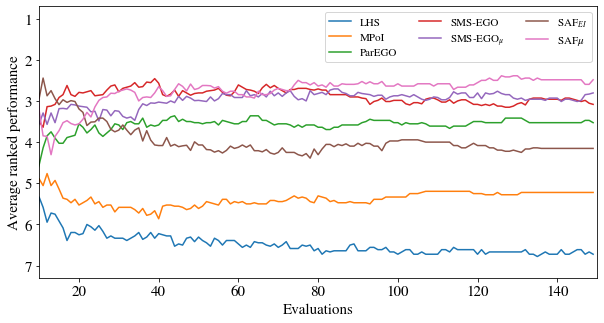

In [333]:
fig = plt.figure(figsize=[10, 5])
ax = fig.gca()
for r in range(7):
    plt.plot(range(0, 150), combined_ranks[:,r, :].mean(axis=0), label=D_names[chosen_optimisers[r]], c=colors[r])
ax.invert_yaxis()
ax.set_xlim([10,150])
ax.set_ylabel('Average ranked performance')
ax.set_xlabel('Evaluations')
ax.legend(ncol=3)
save_fig(fig, name="ranked_performance_plot_hv")


In [334]:
combined_ranks = np.zeros((len(chosen_problems), len(chosen_optimisers), 150))
for prob in range(len(chosen_problems)):
    rank_over_steps = np.zeros((150, 7))
    for i, step in enumerate(range(0, 150)):
        hvss = get_step_metric(prob=prob, step=step, metric='igd+')
        ranks = rank_opts(hvss, True).astype(float)+1
        if i>10:
            sim_ranks = update_ranks(ranks, hvss)
        else:
            sim_ranks = ranks
        rank_over_steps[i, :] = sim_ranks
    combined_ranks[prob] = rank_over_steps.T


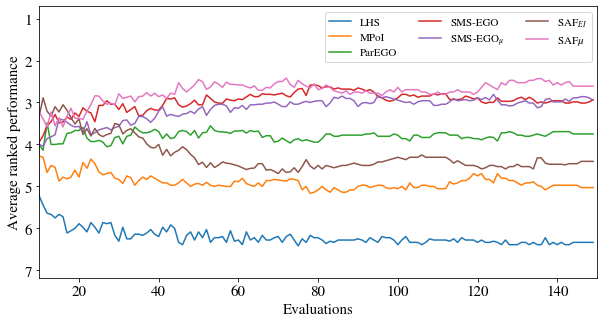

In [337]:
fig = plt.figure(figsize=[10, 5])
ax = fig.gca()
for r in range(7):
    plt.plot(range(0, 150), combined_ranks[:,r, :].mean(axis=0), label=D_names[chosen_optimisers[r]], c=colors[r])
ax.invert_yaxis()
ax.set_xlim([10,150])
ax.set_ylabel('Average ranked performance')
ax.set_xlabel('Evaluations')
ax.legend(ncol=3)
# save_fig(fig, name="ranked_performance_plot_igd")